In [1]:
from models import densenet, resnet
from Model3D import Model3D
from ClassifierDataset import ClassifierDataset

import torch
from torch.autograd import Variable
import torch.utils.data as data
import torchvision.datasets as datasets
import numpy as np
import sys, math, time, os
from random import shuffle

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [2]:
def training_regime(model, data_loader, num_epochs=1, ckpt_file=None, losses_file=None, resume=False):
    losses = list(np.load(losses_file)) if resume else []
    num_batches = len(data_loader)
    for epoch in range(num_epochs):
        print("Epoch %d" % (epoch+1))
        for i, batch in enumerate(data_loader):
            X, y = batch
            
            loss = model.train(Variable(X.type(dtype)), Variable(y.type(dtype)))
            losses.append(loss.data.cpu()[0])

            progress = math.ceil((i+1)/num_batches*20)
            sys.stdout.write('\r[' + progress * '*'+ (20 - progress) * ' ' + '] (%d/%d) Loss: %f' % ((i+1), num_batches, loss.data[0]))

            #if i % 10 == 0:

        model.save(ckpt_file)            
        #np.save(losses_file, losses)    
        print('\n')

In [3]:
X_dataset = ClassifierDataset("/deep/group/shubhang/cands/train/")
X_loader = data.DataLoader(X_dataset, batch_size=20, shuffle=True)

model = Model3D(resnet.resnet18(num_classes=1), pos_weight=4)
#model = Model3D(densenet.densenet121(sample_size=64, sample_duration=64, num_classes=1), pos_weight=4)
#model.load('ckpts/class_train4_ckpt')

In [4]:
experiment_name = 'class_train6'
losses_file = 'losses/' + experiment_name
ckpt_file = experiment_name + '_ckpt'

training_regime(model, X_loader, num_epochs=25, ckpt_file=ckpt_file, losses_file=losses_file)

Epoch 1
[********************] (53/53) Loss: 1.296526

Epoch 2
[********************] (53/53) Loss: 1.241355

Epoch 3
[********************] (53/53) Loss: 1.278989

Epoch 4
[********************] (53/53) Loss: 1.192706

Epoch 5
[********************] (53/53) Loss: 1.420730

Epoch 6
[********************] (53/53) Loss: 0.958034

Epoch 7
[********************] (53/53) Loss: 1.056737

Epoch 8
[********************] (53/53) Loss: 1.614735

Epoch 9
[********************] (53/53) Loss: 1.301769

Epoch 10
[********************] (53/53) Loss: 1.327395

Epoch 11
[********************] (53/53) Loss: 1.353001

Epoch 12
[********************] (53/53) Loss: 1.228332

Epoch 13
[********************] (53/53) Loss: 1.242710

Epoch 14
[********************] (53/53) Loss: 1.227518

Epoch 15
[********************] (53/53) Loss: 1.137360

Epoch 16
[********************] (53/53) Loss: 1.012539

Epoch 17
[********************] (53/53) Loss: 1.002598

Epoch 18
[********************] (53/53) Loss: 1.027419

E

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.externals import joblib

#dev_dataset = ClassifierDataset("/deep/group/shubhang/overfit_class/dev")
#dev_loader = data.DataLoader(dev_dataset, batch_size=20, shuffle=True)

test_dataset = ClassifierDataset("/deep/group/shubhang/overfit_class/test")
test_loader = data.DataLoader(test_dataset, batch_size=29, shuffle=True)

label = 'DenseNet121'

#model = Model3D(resnet.resnet18(num_classes=1), pos_weight=4)
#model.load('ckpts/overfit_class5_ckpt')

model = Model3D(densenet.densenet121(sample_size=64, sample_duration=64, num_classes=1), pos_weight=4)
model.load('ckpts/overfit_class11_ckpt')

#model = joblib.load('nb.pkl') 
#model = joblib.load('svm.pkl')

# models = [model1, model3, model4]

tot_pred, tot_pos, tot_y = [], [], []
tot_acc, tot_sz = 0, 0
for i, batch in enumerate(test_loader):
    X, y = batch
    sz = y.size(0)

    #X = X.numpy().reshape(sz, -1)
    #pred = model.predict(X)
    pred = model.pred(Variable(X.cuda().float()))
    pred = pred.cpu().data.numpy().reshape(sz)

    tot_pred.append(pred)
    tot_y.append(y.numpy().reshape(sz))

pred, y = np.hstack(tot_pred), np.hstack(tot_y)
fpr, tpr, _ = roc_curve(y, pred)
auc = roc_auc_score(y, pred)
print(auc)

plt.plot(fpr,tpr, label=label)
#plt.legend(loc='lower right')
#plt.show()

0.583333333333


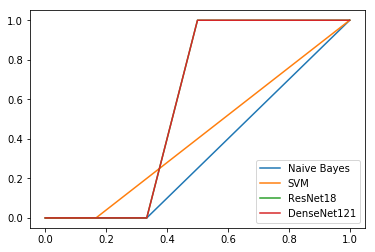

In [39]:
plt.legend(loc='lower right')
plt.show()

0.622023809524


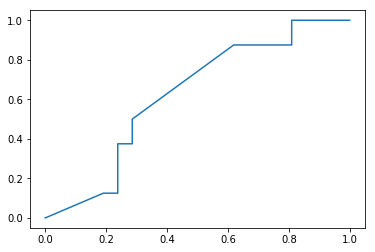

In [3]:
dev_dataset = ClassifierDataset("/deep/group/shubhang/overfit_class/dev")
dev_loader = data.DataLoader(dev_dataset, batch_size=20, shuffle=True)

tot_pred, tot_pos, tot_y = [], [], []
tot_acc, tot_sz = 0, 0
for i, batch in enumerate(dev_loader):
    X, y = batch
    sz = y.size(0)

    pred = model.pred(Variable(X.cuda().float()))
    pred = pred.cpu().data.numpy().reshape(sz)

    tot_pred.append(pred)
    tot_y.append(y.numpy().reshape(sz))

pred, y = np.hstack(tot_pred), np.hstack(tot_y)
fpr, tpr, _ = roc_curve(y, pred)
auc = roc_auc_score(y, pred)
print(auc)

plt.plot(fpr,tpr)

plt.show()

In [31]:
test_dataset = ClassifierDataset("/deep/group/shubhang/overfit_class/test", "/deep/group/shubhang/lcd_data/labels.csv")
test_loader = data.DataLoader(test_dataset, batch_size=29, shuffle=True)

for i, batch in enumerate(dev_loader):
    X, y = batch
    sz = y.size(0)

    pred = model.pred(Variable(X.cuda().float()))
    pred = pred.cpu().data.numpy().reshape(sz)

    tot_pred.append(pred)
    tot_y.append(y.numpy().reshape(sz))

pred, y = np.hstack(tot_pred), np.hstack(tot_y)
fpr, tpr, _ = roc_curve(y, pred)
plt.plot(fpr,tpr, label=labels[num])

plt.legend(loc='lower right')
plt.show()

0.35514018691588783
0.2803738317757009
0.42990654205607476
0.37383177570093457


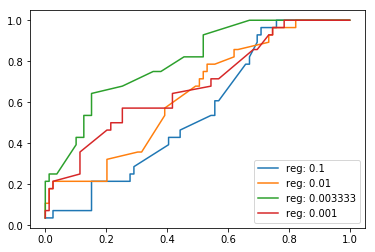

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
ckpts = ['ckpts/overfit_class9_ckpt', 'ckpts/overfit_class10_ckpt', 'ckpts/overfit_class11_ckpt', 'ckpts/overfit_class12_ckpt']
labels = ['reg: 0.1', 'reg: 0.01', 'reg: 0.003333', 'reg: 0.001']

for num, ckpt in enumerate(ckpts):
    model.load(ckpt)
    tot_pred, tot_pos, tot_y = [], [], []
    tot_acc, tot_sz = 0, 0
    for i, batch in enumerate(X_loader):
        X, y = batch
        sz = y.size(0)

        pred = model.pred(Variable(X.cuda().float()))
        pred, y = pred.cpu().data.numpy().reshape(sz), y.numpy().reshape(sz)
        pos = (pred > 0.25).astype(int)

        tot_pred.append(pred)
        tot_pos.append(pos)
        tot_y.append(y)
        tot_acc += len(np.where(pos==y)[0])
        tot_sz += sz

    #print(tot_acc, tot_sz)
    print(tot_acc/tot_sz)

    pred, y = np.hstack(tot_pred), np.hstack(tot_y)
    fpr, tpr, _ = roc_curve(y, pred)
    #auc = roc_auc_score(y, pred)
    label = labels[num]
    plt.plot(fpr, tpr, label=label)
    plt.legend(loc='lower right')
    #print(auc)

plt.show()

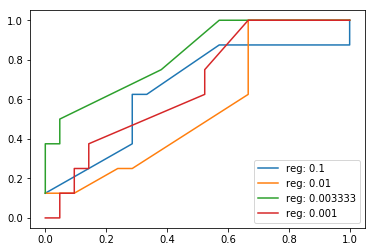

In [8]:
ckpts = ['ckpts/overfit_class9_ckpt', 'ckpts/overfit_class10_ckpt', 'ckpts/overfit_class11_ckpt', 'ckpts/overfit_class12_ckpt']
labels = ['reg: 0.1', 'reg: 0.01', 'reg: 0.003333', 'reg: 0.001']

for num, ckpt in enumerate(ckpts):
    model.load(ckpt)
    tot_pred, tot_y = [], []
    for i, batch in enumerate(dev_loader):
        X, y = batch
        sz = y.size(0)

        pred = model.pred(Variable(X.cuda().float()))
        pred = pred.cpu().data.numpy().reshape(sz)

        tot_pred.append(pred)
        tot_y.append(y.numpy().reshape(sz))

    pred, y = np.hstack(tot_pred), np.hstack(tot_y)
    fpr, tpr, _ = roc_curve(y, pred)
    plt.plot(fpr,tpr, label=labels[num])

plt.legend(loc='lower right')
plt.show()